In [1]:
from gc import callbacks
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st
from keras.src.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import load_model

In [1]:
pharma = ['AGP', 'AMP', 'AMV', 'APC', 'BCP', 'BIO', 'CDP', 'CNC', 'CVN',
       'DAN', 'DBD', 'DBM', 'DBT', 'DCL', 'DDN', 'DHD', 'DHG', 'DHN',
       'DMC', 'DNM', 'DP1', 'DP2', 'DP3', 'DPH', 'DPP', 'DTG', 'DTH',
       'DTP', 'DVM', 'DVN', 'GPC', 'HDP', 'IMP', 'JVC', 'LDP', 'MED',
       'MEF', 'MKP', 'MKV', 'MRF', 'MTP', 'NDC', 'NDP', 'NTF', 'OPC',
       'PBC', 'PMC', 'PPP', 'SPM', 'TNH', 'TRA', 'TTD', 'TVP', 'TW3',
       'UPH', 'VDP', 'VHE', 'VMD', 'YTC']

In [3]:
# dhg imp opc tra
df = pd.read_csv('data/fact_trade_history.csv')

In [4]:
DHG = df[(df.ticker == 'DHG')]
OPC = df[(df.ticker == 'OPC')]
IMP = df[(df.ticker == 'IMP')]
TRA = df[(df.ticker == 'TRA')]

In [5]:
DHG.time = pd.to_datetime(DHG.time)
DHG.set_index('time', inplace=True)
OPC.time = pd.to_datetime(OPC.time)
OPC.set_index('time', inplace=True)
IMP.time = pd.to_datetime(IMP.time)
IMP.set_index('time', inplace=True)
TRA.time = pd.to_datetime(TRA.time)
TRA.set_index('time', inplace=True)

C:\Users\hoang\AppData\Local\Temp\ipykernel_12184\325783386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DHG.time = pd.to_datetime(DHG.time)
C:\Users\hoang\AppData\Local\Temp\ipykernel_12184\325783386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OPC.time = pd.to_datetime(OPC.time)
C:\Users\hoang\AppData\Local\Temp\ipykernel_12184\325783386.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
# DHG['percent_change'] = DHG['close'].pct_change() * 100  
# DHG = DHG.dropna()  
# OPC['percent_change'] = OPC['close'].pct_change() * 100  
# OPC = OPC.dropna()  
# IMP['percent_change'] = IMP['close'].pct_change() * 100  
# IMP = IMP.dropna()
# TRA['percent_change'] = TRA['close'].pct_change() * 100  
# TRA = TRA.dropna() 

In [6]:
DHG = DHG.sort_values(by='time')
OPC = OPC.sort_values(by='time')
IMP = IMP.sort_values(by='time')
TRA = TRA.sort_values(by='time')

In [7]:
DHG.to_csv('data/DHG.csv')
OPC.to_csv('data/OPC.csv')
IMP.to_csv('data/IMP.csv')
TRA.to_csv('data/TRA.csv')

Training model for DHG


In [3]:
del model  # Xóa model cũ
tf.keras.backend.clear_session()  # Giải phóng bộ nhớ

df = pd.read_csv('data/DHG.csv', index_col=0, parse_dates=True)
df.drop('ticker',axis=1,inplace=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột close

def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 30
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Khởi tạo mô hình
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(1)  # Dự đoán giá trị `close`
])

# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])

# Hiển thị kiến trúc mô hình
model.summary()

D:\Projects\stock_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, verbose=2,callbacks=[early_stopping])


Epoch 1/100
70/70 - 5s - 66ms/step - loss: 0.0129 - mae: 0.0769 - val_loss: 0.0020 - val_mae: 0.0322
Epoch 2/100
70/70 - 1s - 11ms/step - loss: 0.0031 - mae: 0.0403 - val_loss: 0.0018 - val_mae: 0.0300
Epoch 3/100
70/70 - 1s - 11ms/step - loss: 0.0027 - mae: 0.0375 - val_loss: 0.0016 - val_mae: 0.0287
Epoch 4/100
70/70 - 1s - 12ms/step - loss: 0.0022 - mae: 0.0336 - val_loss: 0.0017 - val_mae: 0.0292
Epoch 5/100
70/70 - 1s - 12ms/step - loss: 0.0020 - mae: 0.0326 - val_loss: 0.0020 - val_mae: 0.0336
Epoch 6/100
70/70 - 1s - 11ms/step - loss: 0.0017 - mae: 0.0300 - val_loss: 0.0017 - val_mae: 0.0297
Epoch 7/100
70/70 - 1s - 11ms/step - loss: 0.0016 - mae: 0.0293 - val_loss: 0.0039 - val_mae: 0.0548
Epoch 8/100
70/70 - 1s - 11ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 0.0014 - val_mae: 0.0265
Epoch 9/100
70/70 - 1s - 11ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0016 - val_mae: 0.0297
Epoch 10/100
70/70 - 1s - 12ms/step - loss: 0.0014 - mae: 0.0277 - val_loss: 0.0012 - val_m

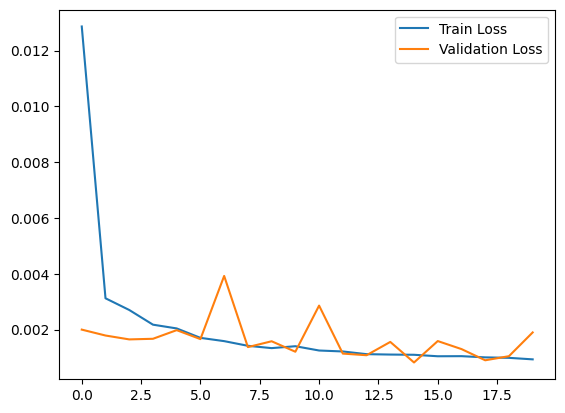

Train Loss: 0.0009
Validation Loss: 0.0019
Test Loss: 0.0002


In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


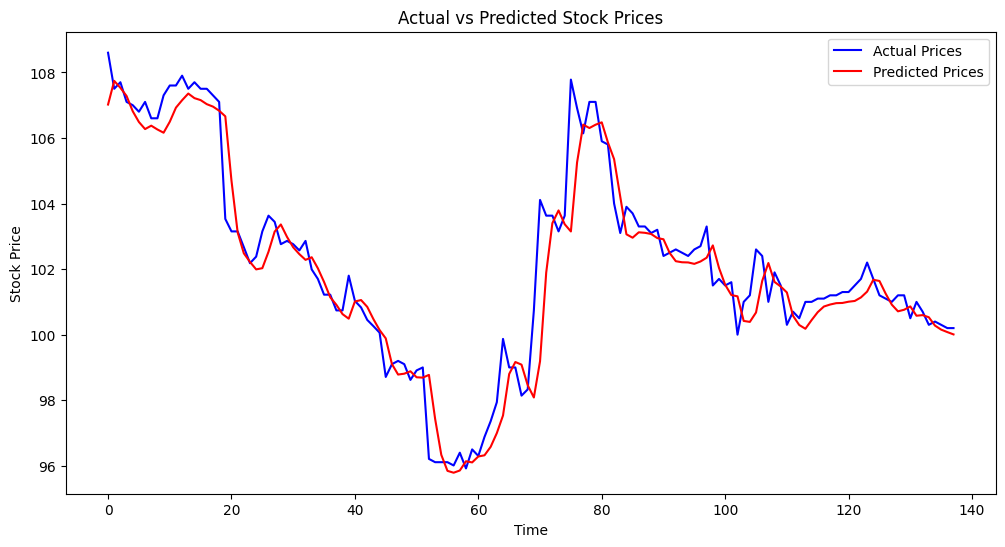

In [171]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.6006
MSE: 0.9194
RMSE: 0.9589
R² Score: 0.9026


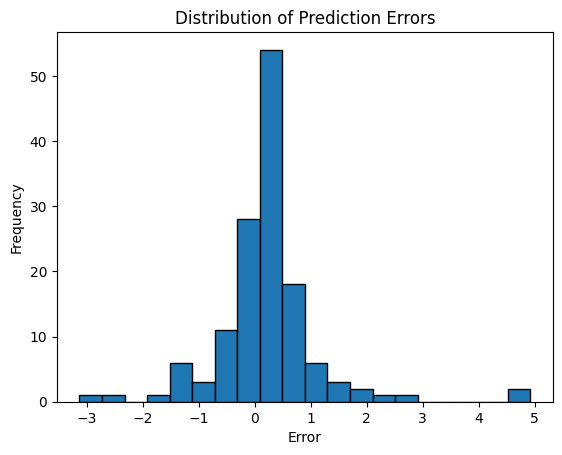

In [172]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

In [173]:
model.save("LSTM_DHG_model.keras")

Training model for IMP

In [4]:
# del model  # Giải phóng bộ nhớ
# tf.keras.backend.clear_session()  # Giải phóng bộ nhớ

df = pd.read_csv('data/IMP.csv', index_col=0, parse_dates=True)
df.drop('ticker',axis=1,inplace=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột 


def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 30
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Khởi tạo mô hình
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Dự đoán giá trị `close`
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Hiển thị kiến trúc mô hình
model.summary()

D:\Projects\stock_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=16, verbose=2,callbacks=[early_stop])

Epoch 1/100
139/139 - 5s - 34ms/step - loss: 0.0040 - mae: 0.0363 - val_loss: 0.0011 - val_mae: 0.0232
Epoch 2/100
139/139 - 2s - 13ms/step - loss: 6.8938e-04 - mae: 0.0186 - val_loss: 8.3677e-04 - val_mae: 0.0216
Epoch 3/100
139/139 - 2s - 12ms/step - loss: 6.4781e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mae: 0.0270
Epoch 4/100
139/139 - 2s - 11ms/step - loss: 5.2070e-04 - mae: 0.0159 - val_loss: 7.0997e-04 - val_mae: 0.0169
Epoch 5/100
139/139 - 2s - 11ms/step - loss: 4.5058e-04 - mae: 0.0146 - val_loss: 0.0018 - val_mae: 0.0344
Epoch 6/100
139/139 - 2s - 11ms/step - loss: 4.3819e-04 - mae: 0.0148 - val_loss: 5.9646e-04 - val_mae: 0.0153
Epoch 7/100
139/139 - 2s - 11ms/step - loss: 3.4454e-04 - mae: 0.0130 - val_loss: 0.0010 - val_mae: 0.0228
Epoch 8/100
139/139 - 2s - 13ms/step - loss: 3.7197e-04 - mae: 0.0134 - val_loss: 5.2135e-04 - val_mae: 0.0156
Epoch 9/100
139/139 - 2s - 11ms/step - loss: 3.6939e-04 - mae: 0.0139 - val_loss: 7.7543e-04 - val_mae: 0.0198
Epoch 10/100
139/139 

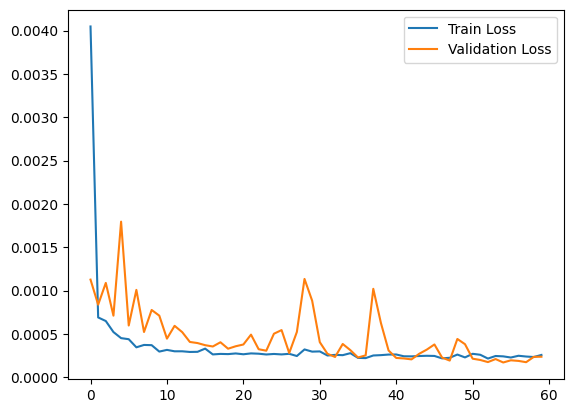

Train Loss: 0.0003
Validation Loss: 0.0002
Test Loss: 0.0006


In [22]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000028963B27740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


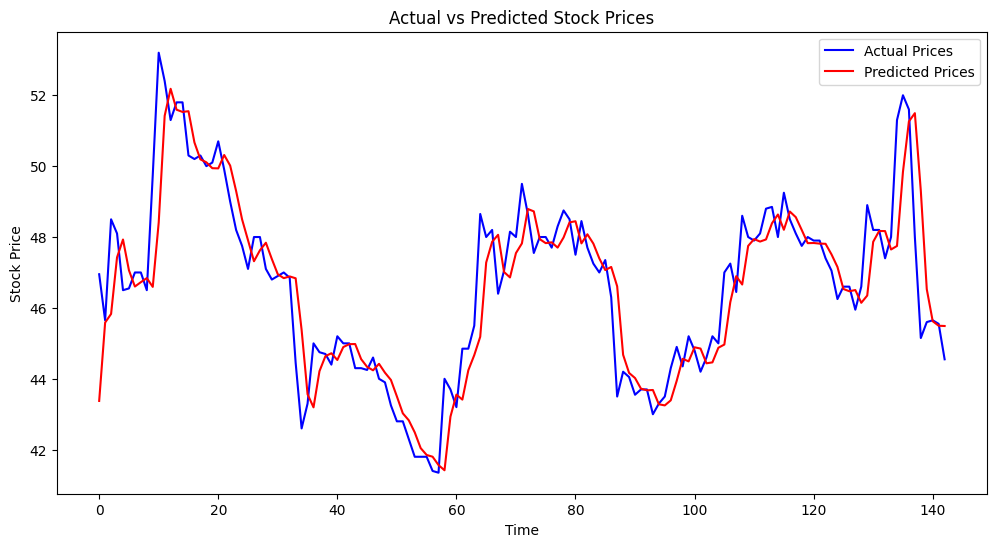

In [23]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.7756
MSE: 1.4384
RMSE: 1.1993
R² Score: 0.7683


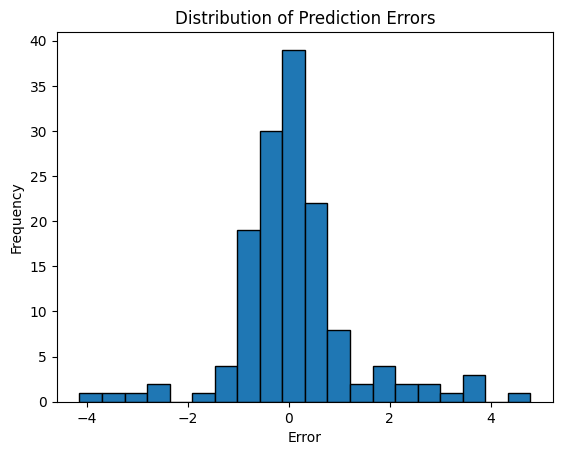

In [24]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# MAE: 1.0409
# MSE: 2.1226
# RMSE: 1.4569
# R² Score: 0.6662

# MAE: 0.9749
# MSE: 2.0546
# RMSE: 1.4334
# R² Score: 0.6769

# MAE: 0.9229
# MSE: 1.8672
# RMSE: 1.3665
# R² Score: 0.7063

# MAE: 0.8626
# MSE: 1.5570
# RMSE: 1.2478
# R² Score: 0.7551

# MAE: 0.8263
# MSE: 1.4680
# RMSE: 1.2116
# R² Score: 0.7691

# Tất cả giữ nguyên, chỉnh LSTM từ 50 lên 100 là dc ( fine tune 1 lần)

Training model for TRA

In [52]:
# del model  # Giải phóng bộ nhớ
# tf.keras.backend.clear_session()  # Giải phóng bộ nhớ
df = pd.read_csv('data/TRA.csv', index_col=0, parse_dates=True)
df.drop('ticker',axis=1,inplace=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột 


def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 30
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Khởi tạo mô hình
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.4),
    Dense(25),
    Dense(1)  # Dự đoán giá trị `close`
])

# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Hiển thị kiến trúc mô hình
model.summary()


D:\Projects\stock_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=16, verbose=2,callbacks=[early_stopping])

Epoch 1/100
139/139 - 5s - 33ms/step - loss: 0.0294 - mae: 0.1163 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 2/100
139/139 - 2s - 11ms/step - loss: 0.0073 - mae: 0.0621 - val_loss: 0.0020 - val_mae: 0.0379
Epoch 3/100
139/139 - 2s - 11ms/step - loss: 0.0059 - mae: 0.0537 - val_loss: 6.0658e-04 - val_mae: 0.0173
Epoch 4/100
139/139 - 2s - 11ms/step - loss: 0.0059 - mae: 0.0537 - val_loss: 8.6479e-04 - val_mae: 0.0216
Epoch 5/100
139/139 - 2s - 11ms/step - loss: 0.0052 - mae: 0.0504 - val_loss: 5.9472e-04 - val_mae: 0.0169
Epoch 6/100
139/139 - 2s - 11ms/step - loss: 0.0048 - mae: 0.0482 - val_loss: 7.1444e-04 - val_mae: 0.0210
Epoch 7/100
139/139 - 2s - 11ms/step - loss: 0.0047 - mae: 0.0476 - val_loss: 9.2850e-04 - val_mae: 0.0232
Epoch 8/100
139/139 - 2s - 11ms/step - loss: 0.0041 - mae: 0.0451 - val_loss: 6.7416e-04 - val_mae: 0.0185
Epoch 9/100
139/139 - 2s - 11ms/step - loss: 0.0042 - mae: 0.0450 - val_loss: 5.4352e-04 - val_mae: 0.0162
Epoch 10/100
139/139 - 2s - 11ms/step - loss:

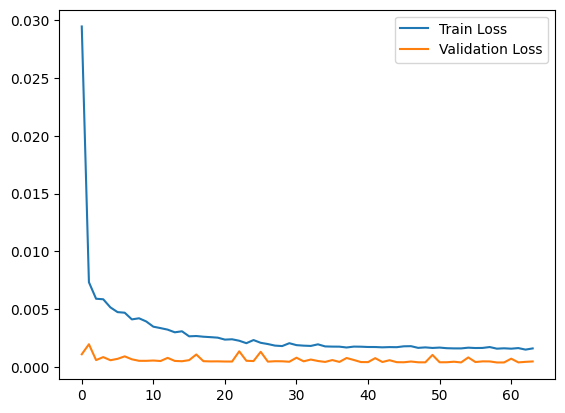

Train Loss: 0.0016
Validation Loss: 0.0005
Test Loss: 0.0001


In [54]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


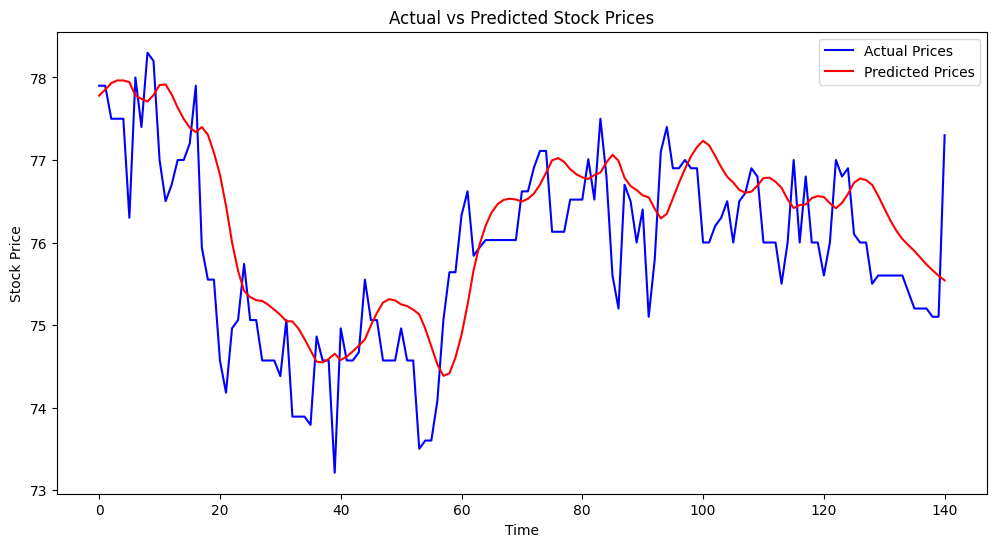

In [55]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.6426
MSE: 0.6357
RMSE: 0.7973
R² Score: 0.4538


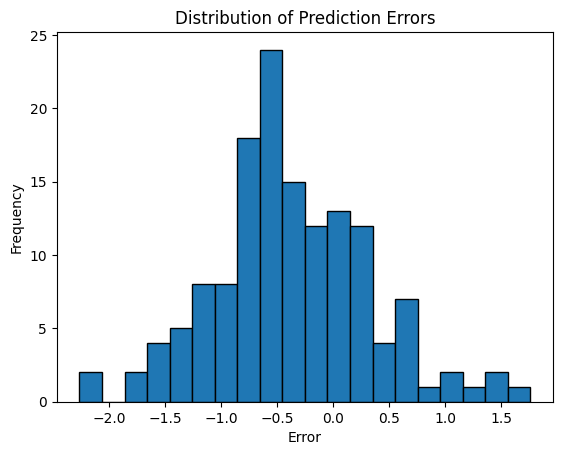

In [56]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

In [130]:
model.save("LSTM_TRA_model.keras")

NameError: name 'model' is not defined

In [8]:
del model  # Giải phóng bộ nhớ
tf.keras.backend.clear_session()  # Giải phóng bộ nhớ

# Đọc dữ liệu
df = pd.read_csv('data/pharma.csv', index_col=0, parse_dates=True)

# Chuẩn hóa dữ liệu nhưng giữ nguyên index
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = df.copy().astype(float)  # Ép kiểu dữ liệu về float64
scaler_close = MinMaxScaler()  # Tạo scaler riêng cho cột close
df['close_scaled'] = scaler_close.fit_transform(df[['close']])  # Chỉ fit_transform cột

def create_sequences(data, lookback=30):
    X, y = [], []
    index_list = data.index.to_list()  # Lấy danh sách thời gian (index)

    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i + lookback].values)  # Lấy 50 điểm làm đầu vào
        y.append(data.iloc[i + lookback, 0])  # Giá trị `close_scaled` tiếp theo làm đầu ra

    return np.array(X), np.array(y), index_list[lookback:]  # Trả về index tương ứng

lookback = 60
# Giả sử bạn đã tạo sequences
X, y, index_list = create_sequences(df[['close_scaled']], lookback=30)

index_list = df_scaled.index[lookback:]  # Lấy index sau khi tạo sequences

# Tạo mask dạng Boolean
train_mask = index_list < '2023-01-01'
val_mask = (index_list >= '2023-01-01') & (index_list < '2024-09-01')
test_mask = index_list >= '2024-09-01'

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Khởi tạo mô hình
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Dự đoán giá trị `close`
])

# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])


# Hiển thị kiến trúc mô hình
model.summary()

NameError: name 'model' is not defined

In [106]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, batch_size=16, verbose = 2, callbacks=[early_stopping])

Epoch 1/100
139/139 - 6s - 42ms/step - loss: 0.0031 - mae: 0.0351 - val_loss: 0.0010 - val_mae: 0.0211
Epoch 2/100
139/139 - 1s - 10ms/step - loss: 8.6481e-04 - mae: 0.0212 - val_loss: 7.9412e-04 - val_mae: 0.0164
Epoch 3/100
139/139 - 1s - 10ms/step - loss: 7.2644e-04 - mae: 0.0196 - val_loss: 0.0012 - val_mae: 0.0255
Epoch 4/100
139/139 - 1s - 10ms/step - loss: 6.6701e-04 - mae: 0.0182 - val_loss: 7.4028e-04 - val_mae: 0.0157
Epoch 5/100
139/139 - 1s - 10ms/step - loss: 5.6215e-04 - mae: 0.0166 - val_loss: 6.6915e-04 - val_mae: 0.0141
Epoch 6/100
139/139 - 1s - 9ms/step - loss: 4.8990e-04 - mae: 0.0155 - val_loss: 9.2750e-04 - val_mae: 0.0232
Epoch 7/100
139/139 - 1s - 9ms/step - loss: 4.6669e-04 - mae: 0.0154 - val_loss: 8.5921e-04 - val_mae: 0.0179
Epoch 8/100
139/139 - 1s - 9ms/step - loss: 4.1714e-04 - mae: 0.0146 - val_loss: 6.5909e-04 - val_mae: 0.0137
Epoch 9/100
139/139 - 1s - 9ms/step - loss: 3.4904e-04 - mae: 0.0134 - val_loss: 7.8184e-04 - val_mae: 0.0196
Epoch 10/100
139/

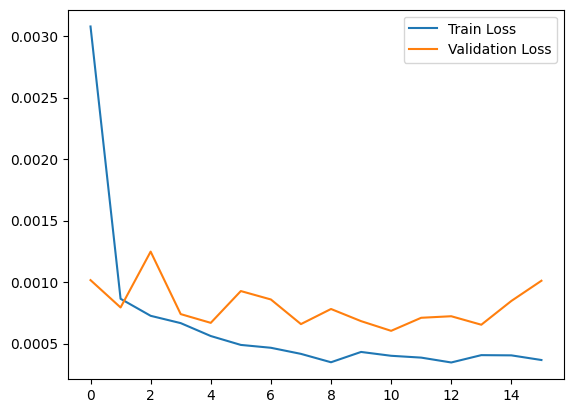

Train Loss: 0.0004
Validation Loss: 0.0010
Test Loss: 0.0016


In [107]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Lấy loss cuối cùng từ history của mô hình đã train
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Nếu có tập test, dự đoán và tính test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
if isinstance(test_loss, list):
    test_loss = test_loss[0]
# In kết quả
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


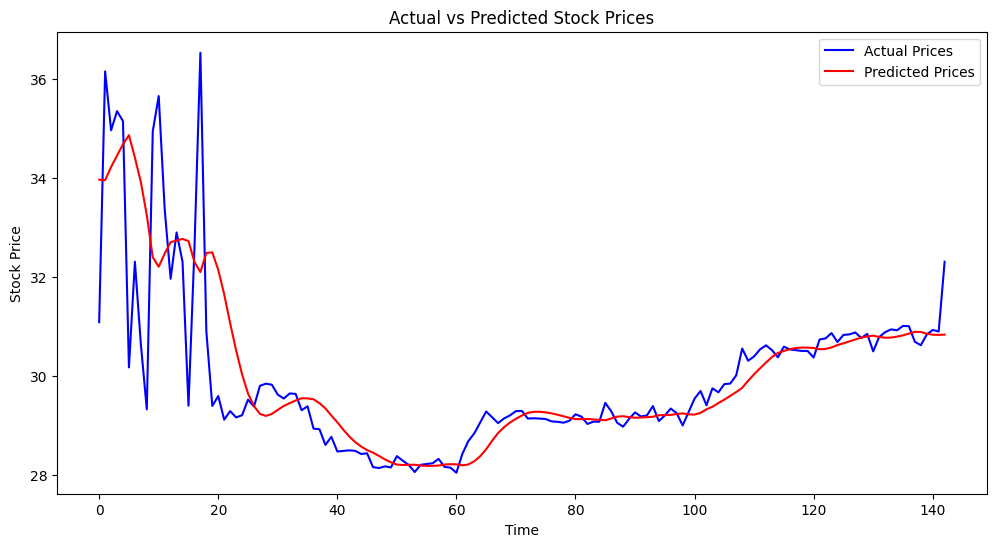

In [108]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Chuyển giá trị dự đoán và thực tế về thang đo ban đầu
y_pred_rescaled = scaler_close.inverse_transform(y_pred.reshape(-1, 1))  # Đảm bảo đúng shape
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))  # Chuyển y_test về dạng (n,1) trước khi inverse_transform

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(y_pred_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

MAE: 0.5377
MSE: 1.1166
RMSE: 1.0567
R² Score: 0.5903


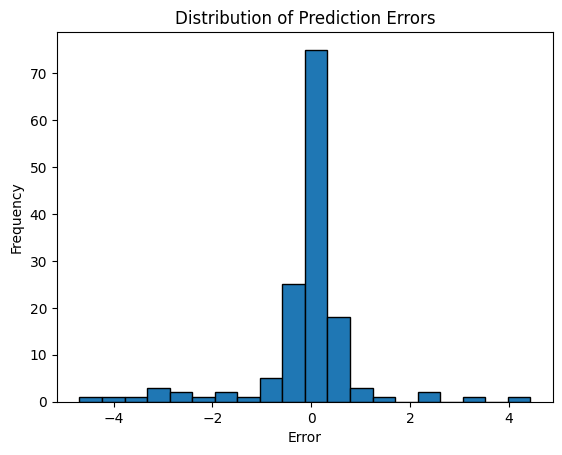

In [109]:
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()
# MAE: 0.5870
# MSE: 1.2113
# RMSE: 1.1006
# R² Score: 0.5555
# MAE: 0.5825
# MSE: 1.1061
# RMSE: 1.0517
# R² Score: 0.5941

In [110]:
model.save("LSTM_pharma_model.keras")